## Training an MLP on Financial Data

## 1. Importing Libraries


In [1]:
# Types
import numpy as np
import pandas as pd

# Preprocessing and Data
import yfinance as yf
from sklearn.model_selection import train_test_split


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Apply the default theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# General ML
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

# Deep Learning (Torch)
import torch
import torch.nn as nn
import torch.optim as optim

## HyperParameters

In [2]:
# MLP Width (Hidden Layers only ofc)
Width = 10**4
# How many previous time-series steps does it use as input features? 
memory_MLP = 15

# N SGD Epochs
N_epochs = 2*(10**1)
Learning_Rate = 10**-3

# Regularization Penality
lambda_value = 10**-6

# 2. Load data

In [3]:
# Load historical stock data from Yahoo Finance
# google_data = yf.download('GOOGL', start='2022-01-01', end='2023-01-01')
# apple_data = yf.download('AAPL', start='2022-01-01', end='2023-01-01')

# Longer Example
google_data = yf.download('GOOGL', start='2010-01-01', end='2023-01-01')
apple_data = yf.download('AAPL', start='2010-01-02', end='2023-01-02')

# Extract the closing prices
google_closing_prices = google_data['Close'].values
apple_closing_prices = apple_data['Close'].values

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 3. Preprocessing

In [4]:
# Combine Google and Apple closing prices into a single DataFrame
df = pd.DataFrame({'Google_Close': google_closing_prices, 'Apple_Close': np.roll(apple_closing_prices, -1)})

# Create a new column for each of the last 15 days' closing prices
for i in range(1, (1+memory_MLP)):
    df[f'Google_Close_{i}'] = df['Google_Close'].shift(i)

# Drop rows with NaN values resulting from the shift
df = df.dropna()

# Normalize the data
df = (df - df.min()) / (df.max() - df.min())

# Split the data into input (X) and output (y)
X_columns = [f'Google_Close_{i}' for i in range(1, (1+memory_MLP))]
y_column = 'Apple_Close'

X = df[X_columns].values
y = df[y_column].values

# Reshape the data for training
X = X.reshape(-1, memory_MLP, 1)
y = y.reshape(-1, 1)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Build Deep Learning Model
We trian a two-hidden layer MLP with ReLU activation function.

In [5]:
input_size = memory_MLP

# Define the neural network architecture for the larger feature vector
class StockPredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, Width)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(Width, Width)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(Width, 1)

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input sequence
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Create an instance of the model with the input size of 15
input_size = memory_MLP
model = StockPredictor(input_size)

# Train Deep Learning Model - $\ell^2$ Penality

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)

We first define the custom loss function, which is just ``MSE`` minimization with an $\ell^2$ regularization penality on the MLP's weights.  This way, we obtain regular models.

In [7]:
# Define L2 regularization function
def l2_regularization(model):
    l2_penalty =  sum([(p**2).sum() for p in model.parameters()])
    return l2_penalty

In [8]:
#+ l2_regularization(model, lambda_value)
# Lists to store training and test losses, y_true, and y_pred
train_losses = []
test_losses = []
y_true_train = []
y_pred_train = []
y_true_test = []
y_pred_test = []

# Training loop
for epoch in range(N_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train) #+ lambda_value*l2_regularization(model)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Store ground truth and predicted values for training set
    with torch.no_grad():
        model.eval()
        y_true_train.extend(y_train.numpy().flatten())
        y_pred_train.extend(outputs.numpy().flatten())
        model.train()

    # Validation (evaluate the model on the test set)
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        y_true_test.extend(y_test.numpy().flatten())
        y_pred_test.extend(test_outputs.numpy().flatten())
        model.train()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{N_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/20], Train Loss: 0.0868, Test Loss: 0.0273
Epoch [20/20], Train Loss: 0.0216, Test Loss: 0.0112


### Compute Errors

In [9]:
# Calculate and report metrics after training
mse_train = mean_squared_error(y_true_train, y_pred_train)
mae_train = mean_absolute_error(y_true_train, y_pred_train)
max_err_train = max_error(y_true_train, y_pred_train)
min_err_train = np.abs(np.array(y_true_train) - np.array(y_pred_train)).min()
std_dev_train = np.std(np.array(y_true_train) - np.array(y_pred_train))

mse_test = mean_squared_error(y_true_test, y_pred_test)
mae_test = mean_absolute_error(y_true_test, y_pred_test)
max_err_test = max_error(y_true_test, y_pred_test)
min_err_test = np.abs(np.array(y_true_test) - np.array(y_pred_test)).min()
std_dev_test = np.std(np.array(y_true_test) - np.array(y_pred_test))

### Compute Test and Training Errors

In [10]:
# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Calculate metrics after training
train_errors.append({
    'MSE': mse_train,
    'MAE': mae_train,
    'Max Error': max_err_train,
    'Min Error': min_err_train,
    'Std Dev': std_dev_train
})

test_errors.append({
    'MSE': mse_test,
    'MAE': mae_test,
    'Max Error': max_err_test,
    'Min Error': min_err_test,
    'Std Dev': std_dev_test
})

# # Create Pandas DataFrames
train_errors_df = pd.DataFrame(train_errors, index=[0])
test_errors_df = pd.DataFrame(test_errors, index=[0])

## Evaluate the model on the test set

In [11]:
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)

print(f'Mean Squared Error on Test Set: {test_loss.item():.4f}')

Mean Squared Error on Test Set: 0.0112


## Make predictions on the entire dataset

In [12]:
with torch.no_grad():
    all_predictions = model(X_tensor)

# Plot the actual vs. predicted closing prices

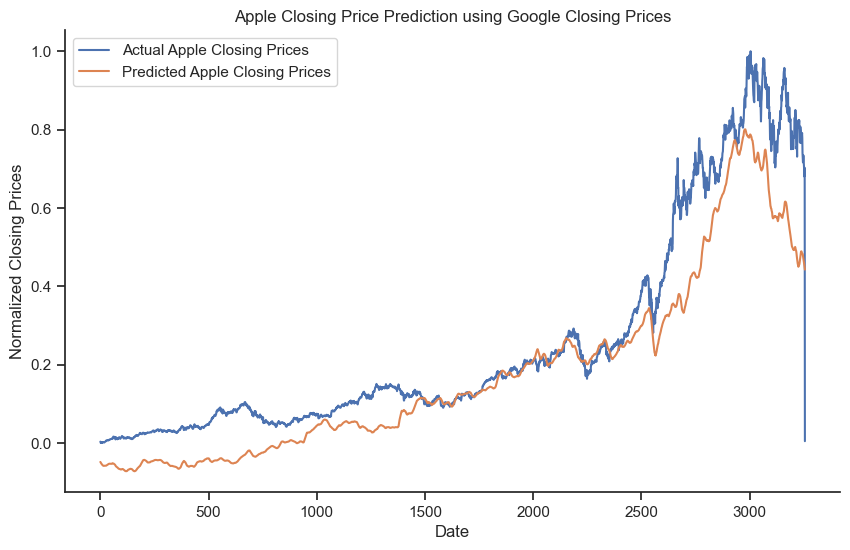

In [13]:
# Plot the actual vs. predicted closing prices
plt.figure(figsize=(10, 6))
plt.plot(y.flatten(), label='Actual Apple Closing Prices')
plt.plot(all_predictions.numpy().flatten(), label='Predicted Apple Closing Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Closing Prices')
plt.title('Apple Closing Price Prediction using Google Closing Prices')
plt.legend()
plt.show()

## Error Visualization:
Let's Visulatize the Training and Test-set Errors

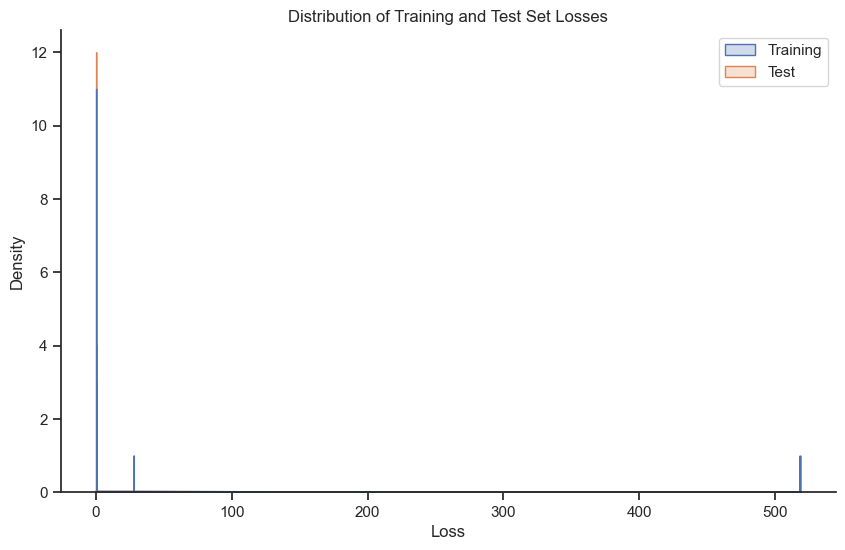

In [14]:
# Plotting the distribution of training and test set losses
plt.figure(figsize=(10, 6))
sns.histplot(data={'Training': train_losses, 'Test': test_losses}, 
             kde=True, 
             element='step', 
             common_norm=False)
plt.title('Distribution of Training and Test Set Losses')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.show()

## Report (Quantitative) Errors

### Train

In [15]:
train_errors_df

,MSE,MAE,Max Error,Min Error,Std Dev
0,27.393026,1.500482,48.878597,9.723008e-07,5.097441


### Test

In [16]:
test_errors_df

,MSE,MAE,Max Error,Min Error,Std Dev
0,27.417706,1.473719,48.779846,0.000009,5.097834


---
# Fin
---

---

---